# Linear Regression Of Global Sales & Crictic Scores
## To see the relationship between Critic Scores and Sales
## To predict sales with given Critic Scores

In [7]:
# Import dependencies
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt
from config import db_password
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
import requests

In [8]:
# Load data
protocol = "postgres"
user = "postgres"
location = "localhost"
port = "5433"
db = "video_game"

connection_string = f'{protocol}://{user}:{db_password}@{location}:{port}/{db}'
engine = create_engine(connection_string)

In [9]:
vgsales_df = pd.read_sql_table('game_sales',con=engine)
vgsales_df.head()

,rank,name,basename,genre,esrb_rating,platform,publisher,developer,vgchartz_score,critic_score,...,na_sales,pal_sales,jp_sales,other_sales,year,last_update,url,status,vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,None,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,None,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,None,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,None,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.0,...,NaN,NaN,NaN,NaN,2009.0,None,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.8,/games/boxart/full_7295041AmericaFrontccc.jpg


In [10]:
vgsales_df.columns.tolist()

['rank',
 'name',
 'basename',
 'genre',
 'esrb_rating',
 'platform',
 'publisher',
 'developer',
 'vgchartz_score',
 'critic_score',
 'user_score',
 'total_shipped',
 'global_sales',
 'na_sales',
 'pal_sales',
 'jp_sales',
 'other_sales',
 'year',
 'last_update',
 'url',
 'status',
 'vgchartzscore',
 'img_url']

In [11]:
vgsales_df.dtypes

rank                int64
name               object
basename           object
genre              object
esrb_rating        object
platform           object
publisher          object
developer          object
vgchartz_score    float64
critic_score      float64
user_score        float64
total_shipped     float64
global_sales      float64
na_sales          float64
pal_sales         float64
jp_sales          float64
other_sales       float64
year              float64
last_update        object
url                object
status              int64
vgchartzscore     float64
img_url            object
dtype: object

In [12]:
vgsales_df.count()

rank              55792
name              55792
basename          55792
genre             55792
esrb_rating       23623
platform          55792
publisher         55792
developer         55775
vgchartz_score        0
critic_score       6536
user_score          335
total_shipped      1827
global_sales      19415
na_sales          12964
pal_sales         13189
jp_sales           7043
other_sales       15522
year              54813
last_update        9186
url               55792
status            55792
vgchartzscore       799
img_url           55792
dtype: int64

In [14]:
# Select Critic_Score & Global_Sales
critic_vs_sales = vgsales_df[['critic_score', 'global_sales']]
critic_vs_sales.head(5)

,critic_score,global_sales
0,7.7,NaN
1,10.0,NaN
2,8.2,NaN
3,NaN,NaN
4,8.0,NaN


In [15]:
critic_vs_sales.count()

critic_score     6536
global_sales    19415
dtype: int64

In [16]:
# Find null value
for column in critic_vs_sales.columns:
    print(f'Column {column} has {critic_vs_sales[column].isnull().sum()} null values')

Column critic_score has 49256 null values
Column global_sales has 36377 null values


In [17]:
critic_vs_sales = critic_vs_sales.dropna()

In [18]:
# Find null value
for column in critic_vs_sales.columns:
    print(f'Column {column} has {critic_vs_sales[column].isnull().sum()} null values')

Column critic_score has 0 null values
Column global_sales has 0 null values


In [19]:
critic_vs_sales.head()

,critic_score,global_sales
19,9.4,20.32
20,9.7,19.39
30,9.6,16.15
40,8.7,14.82
41,8.8,14.74


In [20]:
critic_vs_sales.shape

(4275, 2)

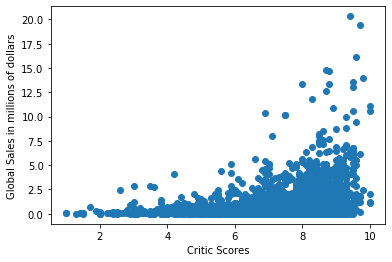

In [22]:
# Visually inspect the relationship between Genre & Global_Sales
plt.scatter(critic_vs_sales.critic_score, critic_vs_sales.global_sales)
plt.ylabel('Global Sales in millions of dollars')
plt.xlabel('Critic Scores')
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

## Prepare for Scikit-learn

In [23]:
# Format the data to meet the requirements of the Scikit-learn library
X = critic_vs_sales.critic_score.values.reshape(-1, 1)

In [24]:
#  Examine the first five entries in X
X[:5]

array([[9.4],
       [9.7],
       [9.6],
       [8.7],
       [8.8]])

In [25]:
X.shape

(4275, 1)

(4275,)


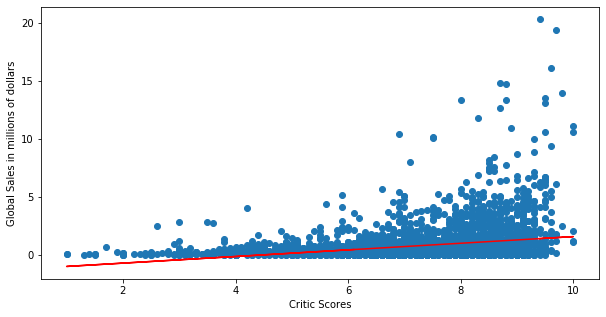

In [26]:
y = critic_vs_sales.global_sales
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
print(y_pred.shape)
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.ylabel('Global Sales in millions of dollars')
plt.xlabel('Critic Scores')
plt.show()

In [27]:
# Examine the specific parameters of our model: the slope and the y-intercept.
# The slope is represented by model.coef_, and model.intercept_ is the y-intercept
print(model.coef_)
print(model.intercept_)

[0.28613215]
-1.288778080575425


In [28]:
# The best fit line is in red, drawn through the predictions.
critic_vs_sales['critic_score'].max()

10.0